In [1]:
# Analyse SSC and fluxes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer
from scipy.ndimage import convolve

# right now, this loads the output into ds_CSYV
%run -i ncbx_funcs.py
# then load the local model output
ds_CSYVc = xr.open_dataset( url_CSYVc )


Shape of xisl, yisl:  (1057, 1317) (1057, 1317)
Index of shoreline and y-location:
[168] [329.27781985]
Offshore model domain (dy_offshore):  [4453.85735021] , onshore (dy_onshore):  [5530.01136684]


In [25]:
print( ds_CSYVc.ocean_time[idx].values )
print( ds_CSYV.ocean_time[idx].values )
print(tstring[idx])

2019-09-06T15:00:00.005992448
2019-09-06T15:00:00.005992448
2019-09-06 15:00


In [62]:
ds_CSYV

<xarray.Dataset> Size: 35GB
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 37,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 64B -0.9375 -0.8125 ... -0.0625
  * s_w                     (s_w) float64 72B -1.0 -0.875 -0.75 ... -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 11MB -76.13 ... -76.19
    lat_rho                 (eta_rho, xi_rho) float64 11MB 34.94 34.94 ... 35.02
    lon_u                   (eta_u, xi_u) float64 11MB ...
    lat_u                   (eta_u, xi_u) float64 11MB ...
    lon_v                   (eta_v, xi_v) float64 11MB ...
    lat_v                   (eta_v, xi_v) float64 11MB ...
    lon_psi                 (eta_psi, xi_psi) float64 11MB ...
    lat_psi                 (eta_psi, xi_psi) float64 11MB ...
  * ocean_time              (ocean_time) datetime64[ns] 296B 2019-09-06T10:15...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 4B ...
    ndtfast                 int32 4B ...
    dt                      float64 8B ...
    dtfast                  float64 8B ...
    dstart                  datetime64[ns] 8B ...
    nHIS                    int32 4B ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 206MB ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00019.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  varinfo.dat
    ...                        ...
    tiling:                    015x012
    history:                   ROMS/TOMS, Version 3.9, Saturday - October 15,...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         8
    EXTRA_DIMENSION.boundary:  4

In [33]:
len(ds_CSYVc.ocean_time)

37

In [142]:
eta_rho = ds_CSYV.sizes['eta_rho']
xi_rho = ds_CSYV.sizes['xi_rho']
s_rho = ds_CSYV.sizes['s_rho']
print(f"eta_rho (y) = {eta_rho}, xi_rho (x) = {xi_rho}")
print(f"s_rho = {s_rho}")
print(np.shape(xisl))

# Smoothing kernal
ik = 15
kernal = np.ones((ik, ik)) / (ik*ik)

#Hz=set_depth(Vtransform, Vstretching, theta_s, theta_b, hc, N, igrid, h, zeta, report)
#Hz=set_depth(2, 4, 0, 0, 0, 8, 1, h, zeta, 1
theta_s = ds_CSYV['theta_s'].values.item()
theta_b = ds_CSYV['theta_b'].values.item()
hc = ds_CSYV['hc'].values.item()
Vtransform = ds_CSYV['Vtransform'].values.item()
Vstretching = ds_CSYV['Vstretching'].values.item()

N=s_rho
idx = 19
# convert to volumetric using island density
rho_bed = .65*2650 # kg/m3


ssc_avg_max = []
ssc_flux_max = []
oflux = []
vflux = []
bdld_max = []
obdld = []
vobdld = []

for idx in range(0,37):
    
    # load bathy
    bath = np.squeeze( -ds_CSYVc.bath[idx,:,:].load().values )
    #baths = convolve(bath, kernal, mode='nearest')
    
    # load water elevation and mask dry regions
    zeta = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
    wdm  = np.squeeze( ds_CSYV.wetdry_mask_rho[idx,:,:].load().values )
    #zeta = despeckle( mask_array( zeta, wdm ) )
    
    zetai = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
    z_w = set_depth_w(-bath, zetai, hc=hc, N=N, Vtransform=Vtransform,
                       Vstretching=Vstretching, theta_s=theta_s, theta_b=theta_b)
    z_rho = set_depth(-bath, zetai, hc=hc, N=N, Vtransform=Vtransform, Vstretching=Vstretching, theta_s=theta_s, theta_b=theta_b, grid='rho')
    
    Hz = np.zeros( (N, eta_rho, xi_rho) )
    sscu = np.zeros( (N, eta_rho, xi_rho) )
    sscv = np.zeros( (N, eta_rho, xi_rho) )
    sscc = np.zeros( (N, eta_rho, xi_rho) )
    
    ssc = np.squeeze( ds_CSYVc.sand_01[idx,:,:,:].load().values + \
            ds_CSYVc.sand_02[idx,:,:,:].load().values + \
            ds_CSYVc.sand_03[idx,:,:,:].load().values)
    
    u_rho = 0.5 * (ds_CSYVc.u[idx, :, :, :-1] + ds_CSYVc.u[idx, :, :, 1:])
    v_rho = 0.5 * (ds_CSYVc.v[idx, :, :-1, :] + ds_CSYVc.v[idx, :, 1:, :])
    u_rho = np.pad(u_rho, ( (0,0), (0,0), (1,1)), mode='edge')
    v_rho = np.pad(v_rho, ( (0,0), (1,1), (0,0)), mode='edge')
    
    for ilevel in range(N):
        Hz[ilevel,:,:] = (z_w[ilevel+1,:,:]-z_w[ilevel,:,:])
        sscc[ilevel,:,:] = ssc[ilevel,:,:] * Hz[ilevel,:,:] # kg/m2
        sscu[ilevel,:,:] = ssc[ilevel,:,:] * u_rho[ilevel,:,:] * Hz[ilevel,:,:] # kg/m/s
        sscv[ilevel,:,:] = ssc[ilevel,:,:] * v_rho[ilevel,:,:] * Hz[ilevel,:,:] # kg/m/s
    
    depth = np.sum( Hz, axis=0 ) # m
    depth = despeckle ( mask_array( depth, wdm ) )
    sscu_tot = np.nansum( sscu, axis=0) #kg/m/s
    sscv_tot = np.nansum( sscv, axis=0) #kg/m/s
    
    ssc_avg = np.nansum( sscc, axis=0)/depth #kg/m3
    ssc_avg = despeckle( mask_array( ssc_avg, wdm ) )
    
    ssc_flux = np.sqrt( sscu_tot**2 + sscv_tot**2 ) # kg/m/s
    
    ssc_avg_max.append( np.nanmax( ssc_avg ) )
    ssc_flux_max.append( np.nanmax( ssc_flux ) )
    oflux_i = 1.5*np.nansum( sscv_tot[168,:] )
    oflux.append( oflux_i )
    vflux.append( oflux_i/rho_bed )
    print(idx, oflux_i )

    bdldu = np.squeeze( ds_CSYV.bedload_Usand_01[idx,:,:].load().values ) + \
            np.squeeze( ds_CSYV.bedload_Usand_02[idx,:,:].load().values ) + \
            np.squeeze( ds_CSYV.bedload_Usand_02[idx,:,:].load().values )
    
    bdldv = np.squeeze( ds_CSYV.bedload_Vsand_01[idx,:,:].load().values ) + \
            np.squeeze( ds_CSYV.bedload_Vsand_02[idx,:,:].load().values ) + \
            np.squeeze( ds_CSYV.bedload_Vsand_02[idx,:,:].load().values )
    
    bdldu = despeckle( mask_array( np.squeeze( bdldu ),
                                  np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) )
    bdldv = despeckle( mask_array( np.squeeze( bdldv ), 
                                  np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) ) )
    
    bdldu = 0.5 * (bdldu[0:-1,:]+bdldu[1:,:])
    bdldv = 0.5 * (bdldv[:,0:-1]+bdldv[:,1:])
    bdld = np.sqrt( bdldu**2 + bdldv**2 )
    bdld_max.append( np.nanmax( bdld ) )
    obdld_i = 1.5*np.nansum( bdldv[168,:] )
    obdld.append( obdld_i )
    vobdld.append( obdld_i/rho_bed )
    print(idx, obdld_i )

eta_rho (y) = 1057, xi_rho (x) = 1317
s_rho = 8
(1057, 1317)
0 -983.6620462670635
0 -8.996003866195679
1 -698.0608945656975
1 4.469427824020386
2 -0.26415361763474765
2 35.431846618652344
3 -645.5653331833287
3 -19.237858772277832
4 -677.3593940669807
4 -32.769264221191406
5 -661.6758576028355
5 -41.074233055114746
6 -627.2707602166815
6 -44.875539779663086
7 -608.853966113123
7 -37.658846855163574
8 -779.1603605817975
8 -194.65729522705078
9 -1438.805454865958
9 -898.7451782226562
10 -3094.483312864514
10 -2246.7147216796875
11 -4056.1238387576896
11 -2514.0472412109375
12 -6386.927064187088
12 -2469.364013671875
13 -8310.519388869148
13 -3220.5823974609375
14 -10001.46926650081
14 -3584.1961669921875
15 -11074.289858892647
15 -4398.5504150390625
16 -11092.19368914298
16 -2714.337890625
17 -10406.185269521284
17 -2659.8275756835938
18 -10193.127461527307
18 -3290.3514404296875
19 -9767.822412586615
19 -3375.180908203125
20 -8382.98980063461
20 -2801.1293334960938
21 -7708.926665266415

Total SSC flux volume: -86724.07
Total bdld flux volume: -26726.71


([<matplotlib.axis.XTick at 0x2a784450b80>,
 [Text(18145.42708380512, 0, '2019-09-06 10:15'),
  Text(18145.468750630735, 0, '2019-09-06 11:15'),
  Text(18145.510417456342, 0, '2019-09-06 12:15'),
  Text(18145.55208312454, 0, '2019-09-06 13:14'),
  Text(18145.59374995015, 0, '2019-09-06 14:14'),
  Text(18145.635416775764, 0, '2019-09-06 15:15'),
  Text(18145.677083601375, 0, '2019-09-06 16:15'),
  Text(18145.718750426986, 0, '2019-09-06 17:15'),
  Text(18145.7604172526, 0, '2019-09-06 18:15')])

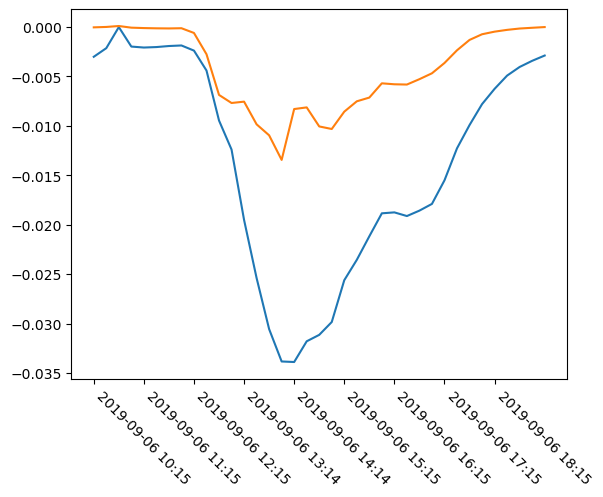

In [143]:
# approximate width of two channesl = 80 + 110 = 190

flux_time =ds_CSYVc.ocean_time.values 
time_seconds = (flux_time - flux_time[0]) / np.timedelta64(1, 's')  # in seconds
# Integrate using trapezoidal rule
total_SSCflux_volume = np.trapz(vflux, x=time_seconds)
total_bdldflux_volume = np.trapz(vobdld, x=time_seconds)

print(f"Total SSC flux volume: {total_SSCflux_volume:.2f}")
print(f"Total bdld flux volume: {total_bdldflux_volume:.2f}")

plt.plot(flux_time, np.array(vflux)/190.)
plt.plot(flux_time, np.array(vobdld)/190.)

xlabels = tstring[0:-1:4]
xticks = flux_time[0:-1:4]
plt.xticks(xticks, xlabels, rotation = -45, ha='left')

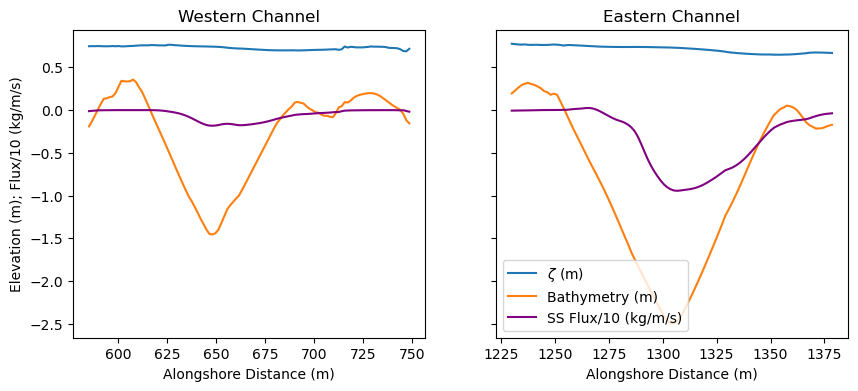

In [138]:
fig, ax = plt.subplots( 1, 2, sharey=True, figsize = (10, 4 ))
ax[0].plot(x[390:500],zeta[168,390:500], label = 'zeta [m]')
ax[0].plot(x[390:500],bath[168,390:500], label = 'Bathy [m]')
ax[0].plot(x[390:500],sscv_tot[168,390:500]/10,'-',c='purple', label='SS Flux/10 [kg/m/s]')
ax[0].set_ylabel('Elevation (m); Flux/10 (kg/m/s)')
ax[0].set_xlabel('Alongshore Distance (m)')
ax[0].set_title('Western Channel')
ax[1].plot(x[820:920],zeta[168,820:920], label = '$\zeta$ (m)')
ax[1].plot(x[820:920],bath[168,820:920], label = 'Bathymetry (m)')
ax[1].plot(x[820:920],sscv_tot[168,820:920]/10,'-',c='purple', label='SS Flux/10 (kg/m/s)')
ax[1].set_xlabel('Alongshore Distance (m)')
ax[1].set_title('Eastern Channel')
ax[1].legend()

In [137]:
# divide flux by width of channels
np.argwhere( sscv_tot[168,:] <-1)

array([[426],
       [427],
       [428],
       [429],
       [430],
       [431],
       [432],
       [433],
       [434],
       [435],
       [436],
       [437],
       [438],
       [439],
       [440],
       [441],
       [442],
       [443],
       [444],
       [445],
       [446],
       [447],
       [448],
       [449],
       [450],
       [451],
       [452],
       [453],
       [454],
       [650],
       [651],
       [652],
       [653],
       [654],
       [689],
       [690],
       [691],
       [692],
       [693],
       [694],
       [695],
       [696],
       [697],
       [698],
       [699],
       [765],
       [766],
       [767],
       [768],
       [769],
       [770],
       [771],
       [772],
       [773],
       [774],
       [852],
       [853],
       [854],
       [855],
       [856],
       [857],
       [858],
       [859],
       [860],
       [861],
       [862],
       [863],
       [864],
       [865],
       [866],
       [867],
      